In [1]:
# Importing packages
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping

# Importing Pauli matrices
from pauli_matrices.pauli_matrices import I, X, Y, Z

# Importing figure properties
from figure_test_files.figure_properties import *

# Importing functions
from hamiltonian.hamiltonian import get_hamiltonian
from Bell_operator.Bell_operator import get_Bell_terms
from Bell_operator.coefficients import get_coefficients
from classical_optimization.classical_optimization import classical_optimization
from correlation_matrix.correlation_matrix import get_correlation_matrix

# Defining saving directory
save_dir = '../data/figures/'

In [2]:
def calc_classical_bound(theta, H, N, m, basis, extra_Z_gate):

    # Obtaining the general correlation matrix
    M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=extra_Z_gate)

    # Adding one to number of measurements to account for the extra z_gate
    if extra_Z_gate:
        m += 1

    # Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
    Bell_terms, indices = get_Bell_terms(M, N, m)

    # Calculating the coefficients
    coeffs = get_coefficients(Bell_terms, H, N)

    # Calculating and returning the classical bound 
    return classical_optimization(coeffs, indices, N, m)


def callback_function(theta):

    # Calculating and returning the classical bound 
    beta_C.append( calc_classical_bound(theta, H, N, m, basis, extra_Z_gate) )

In [3]:
# Defining qubit transform
qubit_transform = 'BK'

# Obtainig Hamiltonian
hamiltonian = get_hamiltonian(qubit_transform = qubit_transform)

# Extracting parameters
H = hamiltonian.matrix_form
N = hamiltonian.N

# Calculating the eigenvalues and eigenstates
eig_vals, eig_vecs = np.linalg.eigh(H)

# Extracting the ground state energy and the respective eigenstate
E_G = eig_vals[0]
psi_G = eig_vecs[:,0]
psi_G_dagger = np.conjugate(np.transpose(psi_G))


In [13]:
# Defining number of measurements and the angle between the two parties
m = 2

# theta = [np.pi/3, np.pi/7, 3*np.pi/5]
theta = np.random.rand((N-1))*2*np.pi
# theta = [0]*3

# Initializing basis and extra Z gate
basis = 'XY'
extra_Z_gate = True

# Obtaining the general correlation matrix
M = get_correlation_matrix(theta, N, m, basis=basis, extra_Z_gate=True)

# Adding one to number of measurements to account for the extra z_gate
if extra_Z_gate:
    m += 1

# Calcuating a list containing all the possible matrices from kronecker products of the observables in the correlation matrix
Bell_terms, indices = get_Bell_terms(M, N, m)

# Calculating the coefficients
coeffs = get_coefficients(Bell_terms, H, N)

# Calculating the classical bound
beta_C = classical_optimization(coeffs, indices, N, m)
beta_C


-1.1912524760321619

In [18]:
M[3,:]

array([[[ 1.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  1.        +0.j        ]],

       [[ 0.        +0.j        ,  0.99970873+0.0241343j ],
        [ 0.99970873-0.0241343j ,  0.        +0.j        ]],

       [[ 0.        +0.j        ,  0.0241343 -0.99970873j],
        [ 0.0241343 +0.99970873j,  0.        +0.j        ]],

       [[ 1.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        , -1.        +0.j        ]]])

In [6]:
# Initializing the Bell operator
B = np.zeros((2**N, 2**N), dtype='complex128')

# Adding terms to the Bell operator
for j in range(len(coeffs)):
    B += coeffs[j]*Bell_terms[j]

# Calculating the difference between the Bell operator and the Hamiltonian
# print(np.sum(np.abs(B-H), axis=(0,1)))

# Calculting the quantum value
beta_Q = np.matmul(psi_G_dagger, np.matmul(B, psi_G))
np.real(beta_Q)

-1.8510456784448648

In [9]:
# Defining the number of measurements
m = 2

# Defining angles
init_guess = np.random.rand((N-1))*2*np.pi

# Defining bounds for the variables
bnds = ((0, 2*np.pi),)*(N-1)

# Defining arguments
basis = 'XY'
extra_Z_gate = True
args = (H, N, m, basis, extra_Z_gate)

# Initializing empty classical bound
beta_C = []

# Defining minimization options
options = {
        'maxiter'  : 2000,
        # 'gtol'     : 1e-12
}

# Creating the basinhopping algorithm
# minimizer_kwargs = {
#                 'method'  : "L-BFGS-B",
#                 'args'    : args,
#                 'jac'     : '2-point',
#                 'bounds'  : bnds,
#                 'options' : options,
#                 'callback': callback_function
# }

minimizer_kwargs = {
                'method'  : "Nelder-Mead",
                'args'    : args,
                # 'jac'     : '2-point',
                # 'bounds'  : bnds,
                'options' : options,
                'callback': callback_function
}

res = basinhopping(calc_classical_bound, init_guess,
                minimizer_kwargs = minimizer_kwargs,
                niter = 0,
                disp = True
)



basinhopping step 0: f -1.19914


Text(0, 0.5, '$\\beta_C$')

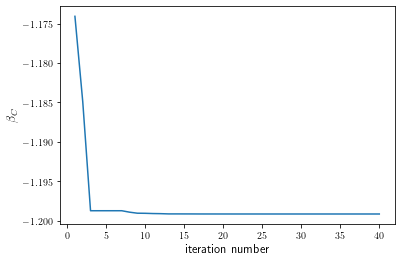

In [10]:
fig, ax = plt.subplots()
ax.plot(np.linspace(1, len(beta_C), len(beta_C)), beta_C)
ax.set_xlabel(r'iteration number')
ax.set_ylabel(r'$\beta_C$')
# ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
# ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3 \pi}{2}$', r'$2\pi$'])
# fig.savefig(save_dir + 'classical_bound_toy_model_varying_basis.png', dpi = 300, bbox_inches='tight');

In [12]:
res


                        fun: -1.1991379999123355
 lowest_optimization_result:  final_simplex: (array([[0.96844229, 4.71235788, 0.65297411],
       [0.96840161, 4.71242052, 0.65297436],
       [0.96840882, 4.71234665, 0.65300155],
       [0.96842385, 4.71243742, 0.65298617]]), array([-1.199138, -1.199138, -1.199138, -1.199138]))
           fun: -1.1991379999123355
       message: 'Optimization terminated successfully.'
          nfev: 81
           nit: 41
        status: 0
       success: True
             x: array([0.96844229, 4.71235788, 0.65297411])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 81
                        nit: 1
                          x: array([0.96844229, 4.71235788, 0.65297411])